### Objective: To determine if doing de novo structure prediction helps with descriptors. 

Previously, I calculated descriptors for mutations of the MPK190 Ab and correlated this with Heparin Binding as measured by ELISA. This gave poor results. WHile, I beleive it is due to the assay, (which is still being developed in House), the poor correlation could be due to the method of creating muations. Here we construct all strucutres De Novo using ABBody Builder 2. 

Note that I ran this on my desktop and I have 2 seperate environments for doing structure prediction versus descriptor calcuation. Below is the code I used for the pytorch environment on my machine that I ran locally. 

```python
import pandas as pd
from ImmuneBuilder import ABodyBuilder2
from pathlib import Path
from tqdm.notebook import tqdm

DATAPATH  = "/Users/ChristopherRivera/Documents/DataResults/MPK190" 
data_path = Path(DATAPATH)

def predict_antibody_structures(sequences, output_dir=None):
    """Given a dataframe with sequences, use ABodyBuilder2 model to predict sequences
    Args: 
        sequence(pd.DataFrame|str|Path): data frame with columns 'Name', 'VH', 'VL'
        output_dir(path|Str): location to save models. 
    Returns: 
        None
    """

    predictor = ABodyBuilder2()
    if isinstance(sequences, str) or isinstance(sequences, Path):
        sequences = pd.read_csv(sequences)
    elif isinstance(sequences, pd.DataFrame): 
        pass
    else:
        print('Not antibodies')

    sequences= sequences.dropna()
    errors=[]

    iterator = zip(sequences['Name'], sequences['VH'], sequences['VL'])
    n = len(sequences)
    for name, hc, lc in tqdm(iterator, total=n):
        sequences = {'H': hc,'L': lc}
        try:
            antibody = predictor.predict(sequences)

            if output_dir: 
                output_file = output_dir/f'{name}.pdb'
                antibody.save(str(output_file))
        except AssertionError:
            
            errors.append(name)
    return errors


# load the data 
mutations_df = pd.read_parquet(data_path/'mutations_data.parquet')
mutations_df = (mutations_df
                .drop_duplicates(subset = ['Vl mutations', 'Vh mutations'])
                .reset_index(drop=True)
                )

# output path
output_path = data_path/'predicted_pdbs'
if not output_path.exists(): 
    output_path.mkdir()

def name_mutation(row): 
    
    vh = row['Vh mutations']
    vl = row['Vl mutations']

    name ='MPK190'
    if vh: 
        vh = '_'.join(vh[1:-1].replace("'",'').replace(' ', '').split(','))
        name += f'_VH_{vh}'

    if vl: 
        vl = '_'.join(vl[1:-1].replace("'",'').replace(' ', '').split(','))
        name += f'_VL_{vl}'

    return name

mutations_df['Name'] = mutations_df.apply(name_mutation, axis = 1)
mutations_df = mutations_df.rename({'Vl': 'VL', 'Vh':'VH'}, axis = 1)

errors = predict_antibody_structures(mutations_df, output_dir=output_path)
```

##### Import Modules and set up paths. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm 

from developability.utils import ls
from developability.pipeline import run_processing_pipeline

In [2]:
DATAPATH  = "/Users/ChristopherRivera/Documents/DataResults/MPK190"   # change this as needed
data_path = Path(DATAPATH)
predicted_pdb_path = data_path/'predicted_pdbs'
pdbs = [f for f in ls(predicted_pdb_path) if f.name.endswith('.pdb')]


In [3]:
descriptors_file = data_path/ 'descriptors_MPK190_predicted.pq'
if not descriptors_file.exists(): 
    descriptors = []

    for pdb in tqdm(pdbs, total = len(pdbs)): 
        descriptors.append(run_processing_pipeline(input_pdb=pdb))
    
    descriptors_df = pd.concat(descriptors)
    descriptors_df.to_parquet(descriptors_file)

else: 
    descriptors_df = pd.read_parquet(descriptors_file)


  0%|          | 0/141 [00:00<?, ?it/s]

Starting pdb4amber with /Users/ChristopherRivera/Documents/DataResults/MPK190/predicted_pdbs/MPK190_VL_G43E_S69E.pdb. 

2023-11-03 20:43:12,450 [MainThread  ] [INFO ]  Executing biobb_amber.pdb4amber.pdb4amber_run Version: 4.1.0
2023-11-03 20:43:12,451 [MainThread  ] [INFO ]  Copy: /Users/ChristopherRivera/Documents/DataResults/MPK190/predicted_pdbs/MPK190_VL_G43E_S69E.pdb to /Users/ChristopherRivera/Projects/developability/Notebooks/ae9ce31a-367d-4e1a-9f61-04a7da3d2fb6
2023-11-03 20:43:12,452 [MainThread  ] [INFO ]  Creating de54966a-8c3d-474f-917d-25a14d1d0e12 temporary folder
2023-11-03 20:43:12,452 [MainThread  ] [INFO ]  pdb4amber -i /Users/ChristopherRivera/Projects/developability/Notebooks/ae9ce31a-367d-4e1a-9f61-04a7da3d2fb6/MPK190_VL_G43E_S69E.pdb -o /Users/ChristopherRivera/Projects/developability/Notebooks/ae9ce31a-367d-4e1a-9f61-04a7da3d2fb6/pdb4amber.pdb -y 

2023-11-03 20:43:13,148 [MainThread  ] [INFO ]  Exit code 0

2023-11-03 20:43:13,149 [MainThread  ] [INFO ]  
Summa

In [4]:
descriptors_df

,HCDR1_APBS_pos,LCDR1_APBS_pos,HCDR2_APBS_pos,LCDR2_APBS_pos,HCDR3_APBS_pos,LCDR3_APBS_pos,HFR1_APBS_pos,LFR1_APBS_pos,HFR2_APBS_pos,LFR2_APBS_pos,...,LFR2_APBS_net,HFR3_APBS_net,LFR3_APBS_net,HFR4_APBS_net,LFR4_APBS_net,HFR5_APBS_net,LFR5_APBS_net,CDR_APBS_pos,CDR_APBS_neg,CDR_APBS_net
MPK190_VL_G43E_S69E,0.0,269.097935,255.021623,0.0,0.0,0.000000,35.295604,3289.220535,0.0,0.000000,...,-281.869032,0.0,897.538642,-88.505805,207.165896,0.0,0.0,4999.230420,-836.345814,4162.884606
MPK190_VL_S69E_A76S,0.0,417.451709,497.657036,0.0,0.0,105.781582,106.250051,3767.202627,0.0,76.020354,...,76.020354,0.0,1163.696069,159.670027,362.248437,0.0,0.0,6655.977892,-69.651674,6586.326218
MPK190_VH_V2D_Q3E_K13Q_VL_R17E_A76S,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,865.873285,0.0,0.000000,...,-186.438243,0.0,323.800657,-138.881801,-291.374534,0.0,0.0,1488.163051,-3031.466637,-1543.303586
MPK190_VH_V5E_VL_S69E_A76S,0.0,147.922432,319.805694,0.0,0.0,0.000000,37.776915,2860.768331,0.0,0.000000,...,-73.960327,0.0,797.738823,-61.710067,186.864528,0.0,0.0,4372.387762,-523.031781,3849.355981
MPK190_VH_Q3E_V5E_K13Q_VL_S69E_A76S,0.0,0.000000,60.346228,0.0,0.0,0.000000,0.000000,1198.803076,0.0,0.000000,...,-153.775253,0.0,470.180350,-86.685943,-103.495685,0.0,0.0,1981.799804,-2165.939205,-184.139401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MPK190_VH_K13Q_VL_R17E,0.0,328.455661,329.169667,0.0,0.0,0.000000,0.000000,2995.761587,0.0,0.000000,...,-142.719992,0.0,667.067620,20.644707,225.461833,0.0,0.0,4655.077177,-914.303892,3740.773285
MPK190_VH_V5E_VL_R17E_S69E_A76S,0.0,97.363975,67.648184,0.0,0.0,0.000000,0.000000,2414.073119,0.0,0.000000,...,-102.964691,0.0,567.556964,39.277744,48.114342,0.0,0.0,3355.003214,-1195.801331,2159.201883
MPK190_VH_K76Q_VL_S69E,0.0,285.112868,232.949485,0.0,0.0,0.000000,56.592228,3240.704964,0.0,0.000000,...,-6.983839,0.0,830.280099,-2.287860,265.978576,0.0,0.0,5044.252482,-652.842244,4391.410238
MPK190_VH_Q3E_K13Q_K76Q,0.0,25.968654,149.336778,0.0,0.0,0.000000,0.000000,1915.352822,0.0,0.000000,...,-135.326359,0.0,563.110904,-27.931578,70.059948,0.0,0.0,2829.864435,-1127.692681,1702.171754


##### Load the table with mutations data and add name column 

In [4]:
def name_mutation(row): 
    
    vh = row['Vh mutations']
    vl = row['Vl mutations']

    name ='MPK190'
    if vh: 
        vh = '_'.join(vh[1:-1].replace("'",'').replace(' ', '').split(','))
        name += f'_VH_{vh}'

    if vl: 
        vl = '_'.join(vl[1:-1].replace("'",'').replace(' ', '').split(','))
        name += f'_VL_{vl}'

    return name


def rename_mutation(row): 
    
    vh = row['Vh mutations']
    vl = row['Vl mutations']

    name ='MPK190'

    if vl: 
        vl = '-'.join(vl[1:-1].replace("'",'').replace(' ', '').split(','))
        name += f'-L-{vl}'
    if vh: 
        vh = '-'.join(vh[1:-1].replace("'",'').replace(' ', '').split(','))
        name += f'-H-{vh}'

    return name


mutations_df = pd.read_parquet(data_path/'mutations_data.parquet')
mutations_df = (mutations_df
                .drop_duplicates(subset = ['Vl mutations', 'Vh mutations'])
                .reset_index(drop=True)
                )
mutations_df.index = mutations_df.apply(name_mutation, axis = 1)
# create a dict to allow renaming
name_map = {name_mutation(row): rename_mutation(row) for _, row in mutations_df.iterrows()}

In [5]:
# get the heparin and organize  per the descriptors df
heparin = mutations_df['heparin binding'].loc[descriptors_df.index]
plate = mutations_df['plate'].loc[descriptors_df.index]
mutations_df = mutations_df.loc[descriptors_df.index]
assert (heparin.index == descriptors_df.index).mean() ==1

In [6]:
heparin_corr_both = (descriptors_df.corrwith(heparin)
                .dropna()
                .sort_values()
                )

heparin_corr_plate1 = (descriptors_df.loc[plate==1].corrwith(heparin)
                       .dropna()
                       .sort_values()
                       )

heparin_corr_plate2 = (descriptors_df.loc[plate==2].corrwith(heparin)
                       .dropna()
                       .sort_values()
                       )

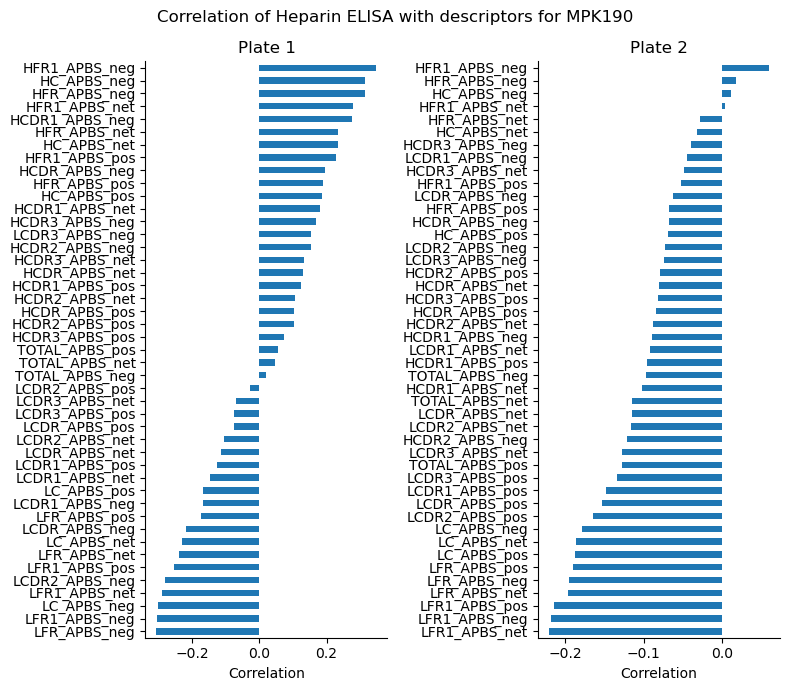

In [7]:
fig, axes = plt.subplots(1,2,figsize = (8, 7))

ax = heparin_corr_plate1.plot(kind = 'barh', ax=axes[0])
ax.set(title = 'Plate 1', xlabel = 'Correlation')
ax = heparin_corr_plate2.plot(kind = 'barh', ax=axes[1])
ax.set(title = 'Plate 2', xlabel = 'Correlation')

sns.despine()
fig.suptitle('Correlation of Heparin ELISA with descriptors for MPK190')
plt.tight_layout()

### Compare the data from plate 1 for predicted versus solved structure. 

In [8]:
solved_descriptors_df = pd.read_parquet( data_path/'MPK190_antibodies_sheet1_descriptors.pq')
plate1_mutations_df = mutations_df.query('plate ==1').copy()
descriptors_df.index = descriptors_df.index.map(name_map)
plate1_descriptors_df = descriptors_df.loc[solved_descriptors_df.index]

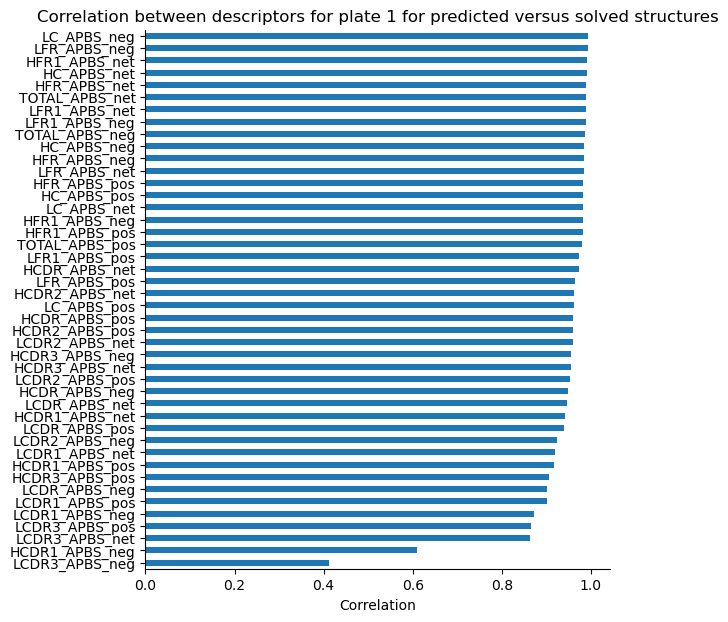

In [9]:
corr_between_methods = (plate1_descriptors_df.corrwith(solved_descriptors_df)
                        .dropna()
                        .sort_values()
                        )
ax = corr_between_methods.plot(kind = 'barh', figsize = (6,7))
ax.set(xlabel='Correlation', title = 'Correlation between descriptors for plate 1 for predicted versus solved structures')

sns.despine()


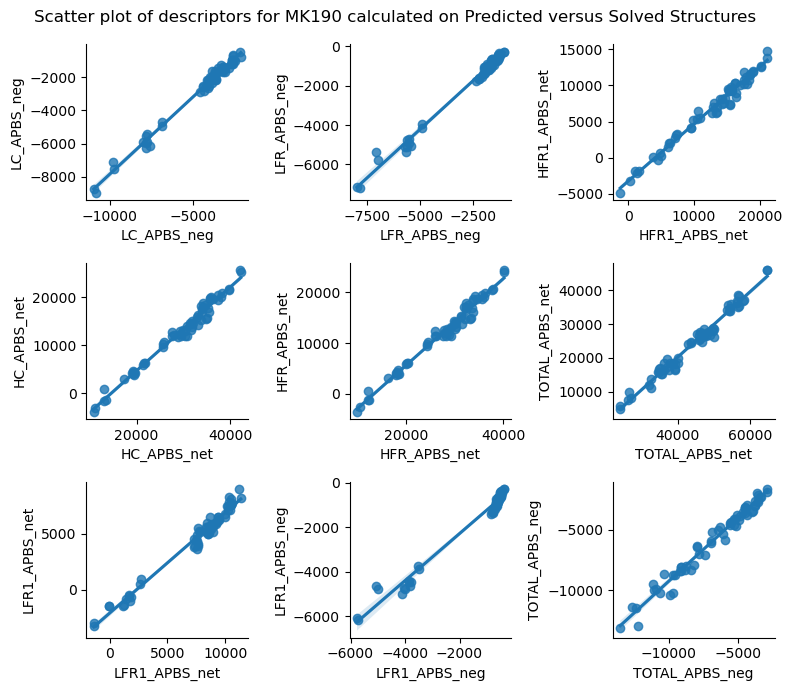

In [10]:
cols = corr_between_methods.sort_values(ascending=False).index[:9]
fig, axes = plt.subplots(3,3, figsize = (8,7))
axes = np.ravel(axes)
for i, col in enumerate(cols): 
    sns.regplot(x=solved_descriptors_df[col], y=plate1_descriptors_df[col], ax = axes[i])

sns.despine()
fig.suptitle('Scatter plot of descriptors for MK190 calculated on Predicted versus Solved Structures')
plt.tight_layout()

In [11]:
corr_between_methods

LCDR3_APBS_neg    0.411259
HCDR1_APBS_neg    0.608581
LCDR3_APBS_net    0.862051
LCDR3_APBS_pos    0.865843
LCDR1_APBS_neg    0.872033
LCDR1_APBS_pos    0.901654
LCDR_APBS_neg     0.902406
HCDR3_APBS_pos    0.906625
HCDR1_APBS_pos    0.916689
LCDR1_APBS_net    0.919061
LCDR2_APBS_neg    0.924820
LCDR_APBS_pos     0.938622
HCDR1_APBS_net    0.942690
LCDR_APBS_net     0.946013
HCDR_APBS_neg     0.947663
LCDR2_APBS_pos    0.952948
HCDR3_APBS_net    0.954707
HCDR3_APBS_neg    0.955751
LCDR2_APBS_net    0.958734
HCDR2_APBS_pos    0.959947
HCDR_APBS_pos     0.960395
LC_APBS_pos       0.961389
HCDR2_APBS_net    0.962767
LFR_APBS_pos      0.963710
HCDR_APBS_net     0.972194
LFR1_APBS_pos     0.972398
TOTAL_APBS_pos    0.978779
HFR1_APBS_pos     0.981209
HFR1_APBS_neg     0.981367
LC_APBS_net       0.982546
HC_APBS_pos       0.983027
HFR_APBS_pos      0.983027
LFR_APBS_net      0.984653
HFR_APBS_neg      0.985108
HC_APBS_neg       0.985135
TOTAL_APBS_neg    0.986577
LFR1_APBS_neg     0.988651
L

### Remarks: 
As we can see above, performing de novo prediction did not improve the performance, thus likely not due to the processing pipeline. 
We also get good correlation between many of the descriptors calculated on the solved-mutated structures versus de novo calculations. 
